<h1> HW3 </h1>

## Q1.a

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as T
import keras
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Merge, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adamax
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from time import time
import multiprocessing as mp
import sys
import math
import argparse
import matplotlib.pyplot as plt

C:\Users\erez\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Define dataset folder and files

In [2]:
MOVIELENS_DIR = 'ml-100k/'
RATING_DATA_FILE = 'u1.base'
RATINGS_CSV_FILE = 'u1_emb.data'
MODEL_WEIGHTS_FILE = 'u1_emb_weights.h5'

The user and item id for embedding should start from 0.
Update ids and save to file

In [3]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(str(len(ratings))+' ratings loaded')
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['userid', 'movieid', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id'])
print('Saved to '+RATINGS_CSV_FILE)

80000 ratings loaded
Saved to u1_emb.data


Load train rating file

In [4]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print(str(len(ratings)), 'ratings loaded.')
print('users '+str(max_userid)+' items '+str(max_movieid))

80000 ratings loaded.
users 943 items 1682


In [5]:
print(ratings)

       userid  movieid  rating  user_emb_id  movie_emb_id
0           1        1       5            0             0
1           1        2       3            0             1
2           1        3       4            0             2
3           1        4       3            0             3
4           1        5       3            0             4
5           1        7       4            0             6
6           1        8       1            0             7
7           1        9       5            0             8
8           1       11       2            0            10
9           1       13       5            0            12
10          1       15       5            0            14
11          1       16       5            0            15
12          1       18       4            0            17
13          1       19       5            0            18
14          1       21       1            0            20
15          1       22       4            0            21
16          1 

Prepare inputs to model

In [6]:
shuffled_ratings = ratings.sample(frac=1.)
Users = shuffled_ratings['user_emb_id'].values
Movies = shuffled_ratings['movie_emb_id'].values
Ratings = shuffled_ratings['rating'].values

In [7]:
shuffled_ratings

,userid,movieid,rating,user_emb_id,movie_emb_id
34867,487,43,3,486,42
6287,109,151,5,108,150
1554,18,476,3,17,475
12674,235,923,4,234,922
53077,660,1133,2,659,1132
48623,625,514,3,624,513
15221,278,313,5,277,312
53966,667,272,5,666,271
47161,611,286,5,610,285
67245,823,144,5,822,143


Define matrix factorization model

In [8]:
def get_model(num_users, num_items, latent_dim):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # 2 dropuot
    conc = Concatenate()([user_latent, item_latent])
    drop = Dropout(0.5)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    # Element-wise product of user and item embeddings
    prediction = merge([user_latent, item_latent], mode = 'dot')
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    return model


Define embedding size and compile model

In [9]:
K_LATENT = 20
hidden_dim = 1
do = 0.5

MF_model = get_model(max_userid,max_movieid,K_LATENT)
MF_model.compile(loss='mse', optimizer='adamax',metrics=['mae'])

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\erez\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("me...)`


## Q1.b

Train model

In [10]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyMF = MF_model.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 6s 89us/step - loss: 13.6786 - mean_absolute_error: 3.5257 - val_loss: 13.6230 - val_mean_absolute_error: 3.5167
Epoch 2/12
64000/64000 [==============================] - 5s 83us/step - loss: 13.0275 - mean_absolute_error: 3.4345 - val_loss: 12.1179 - val_mean_absolute_error: 3.3013
Epoch 3/12
64000/64000 [==============================] - 5s 83us/step - loss: 10.4651 - mean_absolute_error: 3.0293 - val_loss: 8.7033 - val_mean_absolute_error: 2.7098
Epoch 4/12
64000/64000 [==============================] - 5s 84us/step - loss: 6.9970 - mean_absolute_error: 2.3420 - val_loss: 5.6666 - val_mean_absolute_error: 2.0456
Epoch 5/12
64000/64000 [==============================] - 5s 85us/step - loss: 4.7379 - mean_absolute_error: 1.8151 - val_loss: 4.0474 - val_mean_absolute_error: 1.6486
Epoch 6/12
64000/64000 [==============================] - 5s 82us/step - loss: 3.5068 - mean_absolut

In [11]:
def printSumMSE(history):
    loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                         'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                         'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})

    plt.plot(loss['training'])
    plt.plot(loss['validation'])
    plt.title('model rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

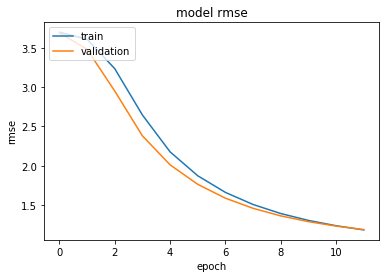

In [12]:
printSumMSE(historyMF)

### Second Model: TODO

## Q1.c

In HW2 we got MAE 0.5956766082578648, in one epoc.
in HW3 we got MAE 0.9192 in 12 epoches
We can understand from above that our pediction model worked better, because we based on non-personal recomandations.



## Q2.a

In [13]:
def get_ncf_model(num_users, num_items, latent_dim,hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    conc = Concatenate()([user_latent, item_latent])
    drop = Dropout(0.5)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    return model

In [14]:
K_LATENT = 20
hidden_dim = 1
do = 0.5

NCF_model = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


## Q2.b

### option 1: 1 hidden layer, K_LATENT(output_dim) = 20, optimizer=Adamax(), loss='mse', activation='relu'.

In [15]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF = NCF_model.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 6s 98us/step - loss: 13.6958 - mean_absolute_error: 3.5280 - val_loss: 13.7189 - val_mean_absolute_error: 3.5297
Epoch 2/12
64000/64000 [==============================] - 5s 79us/step - loss: 13.6958 - mean_absolute_error: 3.5280 - val_loss: 13.7189 - val_mean_absolute_error: 3.5297
Epoch 3/12
64000/64000 [==============================] - 6s 90us/step - loss: 13.6958 - mean_absolute_error: 3.5280 - val_loss: 13.7189 - val_mean_absolute_error: 3.5297


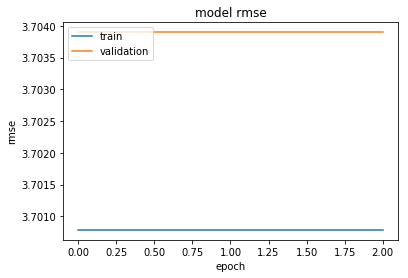

In [16]:
printSumMSE(historyNCF)

### option 1 result: mean_absolute_error: 0.8654

### option2 : 10 hidden layer, K_LATENT(output_dim) = 20, optimizer=Adamax(), loss='mse', activation='relu'.

In [17]:
K_LATENT = 20
hidden_dim = 10
do = 0.5

NCF_model2 = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model2.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [18]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF2 = NCF_model2.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 5s 81us/step - loss: 3.2209 - mean_absolute_error: 1.4340 - val_loss: 1.0471 - val_mean_absolute_error: 0.8427
Epoch 2/12
64000/64000 [==============================] - 4s 67us/step - loss: 1.2991 - mean_absolute_error: 0.9194 - val_loss: 0.9419 - val_mean_absolute_error: 0.7873
Epoch 3/12
64000/64000 [==============================] - 5s 85us/step - loss: 1.0062 - mean_absolute_error: 0.8047 - val_loss: 0.9110 - val_mean_absolute_error: 0.7642
Epoch 4/12
64000/64000 [==============================] - 5s 77us/step - loss: 0.9461 - mean_absolute_error: 0.7774 - val_loss: 0.8975 - val_mean_absolute_error: 0.7553
Epoch 5/12
64000/64000 [==============================] - 8s 119us/step - loss: 0.9279 - mean_absolute_error: 0.7685 - val_loss: 0.8938 - val_mean_absolute_error: 0.7551
Epoch 6/12
64000/64000 [==============================] - 7s 109us/step - loss: 0.9188 - mean_absolute_e

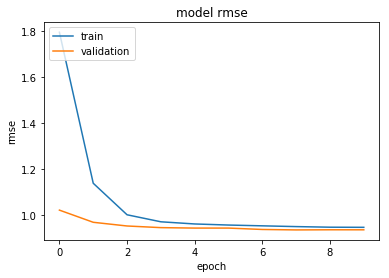

In [19]:
printSumMSE(historyNCF2)

### option 2 result: We got mean_absolute_error: 0.7487

### option 3 : 5 hidden layer, K_LATENT(output_dim) = 10, optimizer=Adamax(), loss='mse', activation='relu'.

In [20]:
K_LATENT = 10
hidden_dim = 5
do = 0.5

NCF_model3 = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model3.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [21]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF3 = NCF_model3.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 4s 67us/step - loss: 4.1422 - mean_absolute_error: 1.6489 - val_loss: 1.2386 - val_mean_absolute_error: 0.9199
Epoch 2/12
64000/64000 [==============================] - 5s 71us/step - loss: 1.2888 - mean_absolute_error: 0.9202 - val_loss: 0.9932 - val_mean_absolute_error: 0.8103
Epoch 3/12
64000/64000 [==============================] - 4s 66us/step - loss: 1.0171 - mean_absolute_error: 0.8116 - val_loss: 0.9373 - val_mean_absolute_error: 0.7733
Epoch 4/12
64000/64000 [==============================] - 5s 77us/step - loss: 0.9793 - mean_absolute_error: 0.7941 - val_loss: 0.9160 - val_mean_absolute_error: 0.7636
Epoch 5/12
64000/64000 [==============================] - 7s 104us/step - loss: 0.9638 - mean_absolute_error: 0.7852 - val_loss: 0.9130 - val_mean_absolute_error: 0.7633
Epoch 6/12
64000/64000 [==============================] - 6s 95us/step - loss: 0.9560 - mean_absolute_er

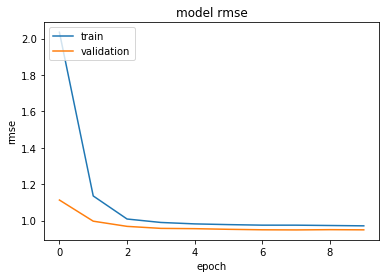

In [22]:
printSumMSE(historyNCF3)

### option 3 result : mean_absolute_error: 0.7639


## Q2.c

## summary:
### option 1 MAE 0.8654
### option 2 MAE 0.7487
### option 3 MAE 0.7639

### So the best is option2!:
### 10 hidden layer, K_LATENT(output_dim) = 20, optimizer=Adamax(), loss='mse', activation='relu'.

#### explanation:                                                                                                                                                                                                      
#### in the neural network, the number of hidden layers is the number of layers that the data is processed. therefore more layers can improve the accuracy of the prediction.   

## Q3.1

### add gender and release year

## Q3.2


In [23]:
m_cols = ['movieid','movie title','release date','video release date','IMDb URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
data_u_item = pd.read_csv('ml-100k/u.item',delimiter='|',names=m_cols,encoding='latin-1')[['movieid','release date']]

In [24]:
#explore users
u_cols = ['userid','age','gender','occupation','zip_code']
data_u_users = pd.read_csv('ml-100k/u.user',delimiter='|',names=u_cols,encoding='latin-1')[['userid','gender']]

### merge shuffled_ratings with movie info and user information

In [25]:
data_u_item.head()

,movieid,release date
0,1,01-Jan-1995
1,2,01-Jan-1995
2,3,01-Jan-1995
3,4,01-Jan-1995
4,5,01-Jan-1995


In [26]:
data_u_users.head()

,userid,gender
0,1,M
1,2,F
2,3,M
3,4,M
4,5,F


In [27]:
shuffled_ratings.head()

,userid,movieid,rating,user_emb_id,movie_emb_id
34867,487,43,3,486,42
6287,109,151,5,108,150
1554,18,476,3,17,475
12674,235,923,4,234,922
53077,660,1133,2,659,1132


In [28]:
movies_ratings_data = shuffled_ratings.merge(data_u_item,on = 'movieid',how = 'inner')

In [29]:
movies_ratings_data = movies_ratings_data.merge(data_u_users,on = 'userid',how = 'inner')

In [30]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
movies_ratings_data['gender'] = lb.fit_transform(movies_ratings_data['gender'])

In [31]:
def parse_date(data):
    new_data = []
    for year in data:
        fix_year = year[-4:]
        new_data.append(fix_year)
    return new_data

In [32]:
# movies_ratings_data['release date'] = parse_date(movies_ratings_data['release date']) 
movies_ratings_data.loc[movies_ratings_data['release date'].isnull(), 'release date'] = '1990'
movies_ratings_data.loc[movies_ratings_data['release date'] == '','release date'] = '1990'
movies_ratings_data['release date'] = parse_date(movies_ratings_data['release date']) 

In [33]:
movies_ratings_data.head()

,userid,movieid,rating,user_emb_id,movie_emb_id,release date,gender
0,487,43,3,486,42,1994,1
1,487,313,3,486,312,1997,1
2,487,272,5,486,271,1997,1
3,487,286,2,486,285,1996,1
4,487,144,5,486,143,1988,1


In [34]:
Users = movies_ratings_data['user_emb_id'].values
Movies = movies_ratings_data['movie_emb_id'].values
Gender = movies_ratings_data['gender'].values
Year = movies_ratings_data['release date'].values
Ratings = movies_ratings_data['rating'].values

In [35]:
def get_ncf_model_4(num_users, num_items, latent_dim,hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    gender_input = Input(shape=(1,), dtype='int32', name = 'gender_input')
    year_input = Input(shape=(1,), dtype='int32', name = 'year_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1) 
    MF_Embedding_Gender = Embedding(input_dim = 2, output_dim = latent_dim, name = 'gender_embedding', input_length=1)
    MF_Embedding_Year = Embedding(input_dim = 2000, output_dim = latent_dim, name = 'year_embedding', input_length=1)  
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    gender_latent = Flatten()(MF_Embedding_Gender(gender_input))
    year_latent = Flatten()(MF_Embedding_Year(year_input))
    
    # Element-wise product of user and item embeddings
    conc = Concatenate()([user_latent, item_latent, gender_latent, year_latent])
    drop = Dropout(0.5)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input, gender_input, year_input], output=prediction)

    return model

In [36]:
K_LATENT = 20
hidden_dim = 10
do = 0.5

NCF_modelQ3 = get_ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_modelQ3.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


### Q3,c

### option 1 K_LATENT = 20, hidden_dim = 10 optimizer=Adamax()

In [37]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCFQ3 = NCF_modelQ3.fit([Users, Movies, Gender, Year], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 7s 104us/step - loss: 2.8728 - mean_absolute_error: 1.3594 - val_loss: 1.3911 - val_mean_absolute_error: 0.9913
Epoch 2/12
64000/64000 [==============================] - 7s 103us/step - loss: 1.3377 - mean_absolute_error: 0.9326 - val_loss: 1.1841 - val_mean_absolute_error: 0.9040
Epoch 3/12
64000/64000 [==============================] - 6s 95us/step - loss: 1.0138 - mean_absolute_error: 0.8079 - val_loss: 1.1412 - val_mean_absolute_error: 0.8811
Epoch 4/12
64000/64000 [==============================] - 6s 97us/step - loss: 0.9487 - mean_absolute_error: 0.7788 - val_loss: 1.1107 - val_mean_absolute_error: 0.8643
Epoch 5/12
64000/64000 [==============================] - 6s 96us/step - loss: 0.9234 - mean_absolute_error: 0.7684 - val_loss: 1.1054 - val_mean_absolute_error: 0.8615
Epoch 6/12
64000/64000 [==============================] - 7s 110us/step - loss: 0.9108 - mean_absolute_

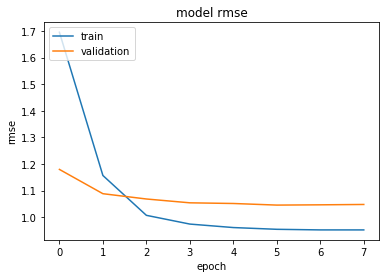

In [38]:
printSumMSE(historyNCFQ3)

### option2 K_LATENT = 20, hidden_dim = 10 optimizer=Adagrad

In [39]:
K_LATENT = 20
hidden_dim = 10
do = 0.5

NCF_modelQ3 = get_ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_modelQ3.compile(loss='mse',optimizer=Adagrad(),metrics=['mae'])
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCFQ3 = NCF_modelQ3.fit([Users, Movies, Gender, Year], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 6s 101us/step - loss: 2.8514 - mean_absolute_error: 1.3611 - val_loss: 1.6566 - val_mean_absolute_error: 1.0958
Epoch 2/12
64000/64000 [==============================] - 6s 90us/step - loss: 2.2897 - mean_absolute_error: 1.2145 - val_loss: 1.5634 - val_mean_absolute_error: 1.0605
Epoch 3/12
64000/64000 [==============================] - 6s 91us/step - loss: 2.0590 - mean_absolute_error: 1.1520 - val_loss: 1.4890 - val_mean_absolute_error: 1.0320
Epoch 4/12
64000/64000 [==============================] - 6s 91us/step - loss: 1.8887 - mean_absolute_error: 1.1037 - val_loss: 1.4431 - val_mean_absolute_error: 1.0133
Epoch 5/12
64000/64000 [==============================] - 6s 92us/step - loss: 1.7600 - mean_absolute_error: 1.0636 - val_loss: 1.4165 - val_mean_absolute_error: 1.0026
Epoch 6/12
64000/64000 [==============================] - 6s 92us/step - loss: 1.6677 - mean_absolute_er

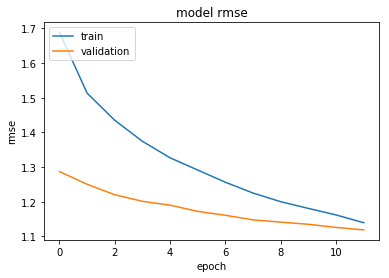

In [40]:
printSumMSE(historyNCFQ3)

# option3 K_LATENT = 7, hidden_dim = 5 optimizer=RMSprop :

In [63]:
K_LATENT = 20
hidden_dim = 10
do = 0.8

NCF_modelQ3 = get_ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_modelQ3.compile(loss='mse',optimizer=RMSprop(),metrics=['mae'])
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCFQ3 = NCF_modelQ3.fit([Users, Movies, Gender, Year], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 8s 122us/step - loss: 4.3978 - mean_absolute_error: 1.7269 - val_loss: 2.0037 - val_mean_absolute_error: 1.2244
Epoch 2/12
64000/64000 [==============================] - 7s 105us/step - loss: 1.4228 - mean_absolute_error: 0.9672 - val_loss: 1.2098 - val_mean_absolute_error: 0.9203
Epoch 3/12
64000/64000 [==============================] - 7s 108us/step - loss: 1.0749 - mean_absolute_error: 0.8444 - val_loss: 1.1409 - val_mean_absolute_error: 0.8888
Epoch 4/12
64000/64000 [==============================] - 7s 110us/step - loss: 1.0685 - mean_absolute_error: 0.8420 - val_loss: 1.1599 - val_mean_absolute_error: 0.9026
Epoch 5/12
64000/64000 [==============================] - 7s 112us/step - loss: 1.0539 - mean_absolute_error: 0.8351 - val_loss: 1.1464 - val_mean_absolute_error: 0.8969


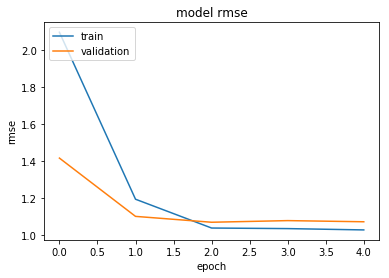

In [65]:
printSumMSE(historyNCFQ3)